In [41]:
# %load /Users/Yifan/Desktop/CarND/CarND-Vehicle-Detection/car_detection_func.py
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
from scipy.ndimage.measurements import label

def data_look(car_list,not_car_list):
	data_dict = {}
	data_dict["n_cars"] = len(car_list)
	data_dict["n_notcars"] = len(not_car_list)
	example_img = mpimg.imread(car_list[0])
	data_dict["image_shape"] = example_img.shape
	data_dict["data_type"] = example_img.dtype 
	return data_dict



# a function to extract features from a list of images# a fun 

# a function to extract features from a list of images# a fun 
def extract_features(imgs, cspace='RGB', spatial_size=(32,32), hist_bins=32, 
                    orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, vis=False, 
                    feature_vec=True):
    features = []

    for file in imgs:
        
        file_feat = []
        
        img = mpimg.imread(file)

        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)
    
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_feat.append(spatial_features)
        ##print(spatial_features.shape)

        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_feat.append(hist_features)
        ##print(hist_features.shape)

        if hog_channel == 'ALL':
            hog_features = []

            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient, 
                                pix_per_cell, cell_per_block, vis, feature_vec))

            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                        pix_per_cell, cell_per_block, vis, feature_vec)
            
        file_feat.append(hog_features)

        features.append(np.concatenate(file_feat))

    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis:
        return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                cells_per_block=(cell_per_block,cell_per_block), visualise=vis, 
                feature_vector=feature_vec,transform_sqrt=False)

        hog_features = return_list[0]
        hog_image = return_list[1]

        return hog_features, hog_image
    else:
        hog_features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                cells_per_block=(cell_per_block,cell_per_block), visualise=vis, 
                feature_vector=feature_vec,transform_sqrt=False)

        return hog_features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def  convert_color (img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]  # sub-sampling
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #nblocks_per_window = (window // pix_per_cell)-1 

    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
   
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(test_stacked)    
            #test_features = scaler.transform(np.array(features).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))

    return draw_img, bboxes


def add_heat(heatmap, bbox_list):
	for box in bbox_list:
		
		heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

	return heatmap


def apply_threshold(heatmap, threshold):
	heatmap[heatmap <= threshold] = 0

	return heatmap

def draw_labeled_bboxes(img, labels):
	for car_number in range(1, labels[1] + 1):
		nonzero = (labels[0] == car_number).nonzero()
		nonzeroy = np.array(nonzero[0])
		nonzerox = np.array(nonzero[1])
		bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

		cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

	return img


def detect_cars_with_heat(img, svc, X_scaler, orient, pix_per_cell,
				cell_per_block, spatial_size, hist_bins, heatmap_threshold):
	
	out_img, bbox_list = apply_sliding_window(img, svc, X_scaler,orient,
							pix_per_cell, cell_per_block, spatial_size, hist_bins)

	heat_zero = np.zeros_like(img[:,:,0].astype(np.float))
	heat_add_box = add_heat(heat_zero, bbox_list)
	heat_add_box_thres = apply_threshold(heat_add_box, heatmap_threshold)

	heatmap = np.clip(heat_add_box_thres, 0, 255)
	labels = label(heatmap)
	draw_img = draw_labeled_bboxes(np.copy(img), labels)


	return draw_img	



def apply_sliding_window(image, svc, X_scaler,orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bboxes = []
    ystart = 400
    ystop = 500 
    out_img, bboxes1 = find_cars(image, ystart, ystop, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 500 
    out_img, bboxes2 = find_cars(out_img, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 410
    ystop = 500 
    out_img, bboxes3 = find_cars(out_img, ystart, ystop, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 420
    ystop = 556 
    out_img, bboxes4 = find_cars(out_img, ystart, ystop, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes5 = find_cars (out_img, ystart, ystop, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes6 = find_cars (out_img, ystart, ystop, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 440
    ystop = 556 
    out_img, bboxes7 = find_cars (out_img, ystart, ystop, 1.9, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes8 = find_cars (out_img, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes9 = find_cars (out_img, ystart, ystop, 2.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 500 
    ystop = 656 
    out_img, bboxes10 = find_cars (out_img, ystart, ystop, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bboxes1)
    bboxes.extend(bboxes2)
    bboxes.extend(bboxes3)
    bboxes.extend(bboxes4)
    bboxes.extend(bboxes5)
    bboxes.extend(bboxes6)
    bboxes.extend(bboxes7)
    bboxes.extend(bboxes8)
    bboxes.extend(bboxes9)
    bboxes.extend(bboxes10)
    
    return out_img, bboxes


##------------------------------------------------------------------------------------
##------------------------------------------------------------------------------------


def hog_extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, 
					hog_channel=0, vis=False, feature_vec=True):
	features = []

	for file in imgs:
		img = mpimg.imread(file)
		

		if cspace != 'RGB':
			if cspace == 'HSV':
				feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
			elif cspace == 'LUV':
				feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
			elif cspace == 'HLS':
				feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
			elif cspace == 'YUV':
				feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
			elif cspace == 'YCrCb':
				feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
		else: feature_image = np.copy(img)

		
		if hog_channel == 'ALL':
			hog_features = []

			for channel in range(feature_image.shape[2]):
				hog_features.append(get_hog_features(feature_image[:,:,channel], orient, 
								pix_per_cell, cell_per_block, vis, feature_vec))

			hog_features = np.ravel(hog_features)
		else:
			hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
								pix_per_cell, cell_per_block, vis, feature_vec)

		features.append(hog_features)

	return features




def hog_find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
	draw_img = np.copy(img)
	img = img.astype(np.float32)/255
	box_list = []

	img_tosearch = img[ystart:ystop, :, :]
	ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')

	if scale!= 1:
		imshape = ctrans_tosearch.shape
		ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

	ch1 = ctrans_tosearch[:,:,0]
	ch2 = ctrans_tosearch[:,:,1]
	ch3 = ctrans_tosearch[:,:,2]

	nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1	
	nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
	nfeat_per_block = orient * cell_per_block ** 2

	window = 64 
	nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
	cells_per_step = 2
	nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1 
	nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

	hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
	hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
	hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
	

	for xb in range(nxsteps):
		for yb in range(nysteps):
			ypos = yb * cells_per_step
			xpos = xb * cells_per_step

			hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
			hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
			hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
			hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

			xleft = xpos * pix_per_cell
			ytop = ypos * pix_per_cell


			test_features = X_scaler.transform((hog_features).reshape(1,-1))
			test_prediction = svc.predict(test_features)

			if test_prediction == 1:
				xbox_left = np.int(xleft * scale)
				ytop_draw = np.int(ytop * scale)
				win_draw = np.int(window * scale)

				cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart), (xbox_left + win_draw, 
							ytop_draw + win_draw + ystart), (0,0,255), 6)
				box_list.append(( (int(xbox_left), int(ytop_draw + ystart)), 
						(int(xbox_left + win_draw), int(ytop_draw + win_draw + ystart)) ))

	return draw_img, box_list



def hog_detect_cars_with_heat(img, svc, X_scaler, orient, pix_per_cell,
				cell_per_block, heatmap_threshold):
	
	out_img, bbox_list = hog_apply_sliding_window(img, svc, X_scaler, orient, 
							pix_per_cell, cell_per_block)

	heat_zero = np.zeros_like(img[:,:,0].astype(np.float))
	heat_add_box = add_heat(heat_zero, bbox_list)
	heat_add_box_thres = apply_threshold(heat_add_box, heatmap_threshold)

	heatmap = np.clip(heat_add_box_thres, 0, 255)
	labels = label(heatmap)
	draw_img = draw_labeled_bboxes(np.copy(img), labels)


	return draw_img	



def hog_apply_sliding_window(img, svc, X_scaler, orient, pix_per_cell, cell_per_block):
	bbox_list = []
	ystart = 400
	ystop = 480
	out_img, box1 = hog_find_cars(img, ystart, ystop, 1.0, svc, X_scaler, orient, pix_per_cell, 
							cell_per_block)
	
	ystart = 400
	ystop = 560
	out_img, box2 = hog_find_cars(out_img, ystart, ystop, 1.5, svc, X_scaler, orient, pix_per_cell, 
							cell_per_block)
	
	ystart = 400
	ystop = 620
	out_img, box3 = hog_find_cars(out_img, ystart, ystop, 1.7, svc, X_scaler, orient, pix_per_cell, 
							cell_per_block)
	
	ystart = 400
	ystop = 656
	out_img, box4 = hog_find_cars(out_img, ystart, ystop, 2, svc, X_scaler, orient, pix_per_cell, 
							cell_per_block)
	
	bbox_list.extend(box1)
	bbox_list.extend(box2)
	bbox_list.extend(box3)
	bbox_list.extend(box4)
	

	
	return out_img, bbox_list

print('Finished.')

Finished.


In [2]:
# %load /Users/Yifan/Desktop/CarND/CarND-Vehicle-Detection/main.py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
import numpy as np 
import cv2
import glob
import time
from sklearn.svm import NuSVC,LinearSVC
from sklearn import svm, tree
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from car_detection_func import *

cars = []
not_cars = []

all_cars = glob.glob('/Users/Yifan/Desktop/CarND/CarND-Vehicle-Detection/vehicles/*/*.png')

all_not_cars = glob.glob('/Users/Yifan/Desktop/CarND/CarND-Vehicle-Detection/non-vehicles/*/*.png')

for i, car in enumerate(all_cars):
	if i % 5 == 0:
		cars.append(car)

for i, not_car in enumerate(all_not_cars):
	if i % 5 == 0:
		not_cars.append(not_car)

data_info = data_look(cars,not_cars)

print("n_cars:" ,data_info["n_cars"] , "    n_notcars   :" , data_info["n_notcars"])


n_cars: 1759     n_notcars   : 1794


# Test begin

# Test with HOG, Color and Hist

In [42]:
spatial = 32
histbin = 32
colorspace = 'YUV'
orient = 15
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

t = time.time()
car_features = extract_features(cars, cspace=colorspace, spatial_size=(spatial, spatial),
						hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell,
						cell_per_block=cell_per_block,hog_channel=hog_channel)
notcar_features = extract_features(not_cars, cspace=colorspace, spatial_size=(spatial, spatial),
						hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell,
						cell_per_block=cell_per_block,hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t),'Seconds to extract spatial, hist and HOG features....')

X = np.vstack((car_features, notcar_features)).astype(np.float64)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using: ', orient, 'orientations', pix_per_cell, 'pixels_per_cell and', cell_per_block,
		'cells_per_block')
print('Feature vector length: ', len(X_train[0]))

##svc = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20,10,5,2))
svc = LinearSVC()
#svc = SGDClassifier(loss="hinge", penalty="l2")
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t), 'Seconds to train SVC.....')
print('Test Accuracy of SVC= ', round(svc.score(X_test, y_test), 4))

t = time.time()
n_predict = 10
print('My SVC predicts', svc.predict(X_test[0:n_predict]))
print('For that ', n_predict, 'labels:', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t), 'Seconds to predict', n_predict, 'labels with SVC')

##----------------------------------------------------------------------------------------

/Users/Yifan/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


23 Seconds to extract spatial, hist and HOG features....
Using:  15 orientations 8 pixels_per_cell and 2 cells_per_block
Feature vector length:  11988
2 Seconds to train SVC.....
Test Accuracy of SVC=  0.9887
My SVC predicts [0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
For that  10 labels: [0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
0 Seconds to predict 10 labels with SVC


/Users/Yifan/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


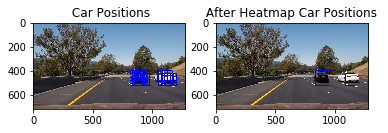

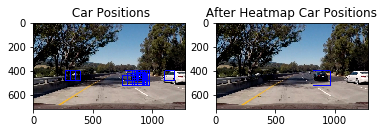

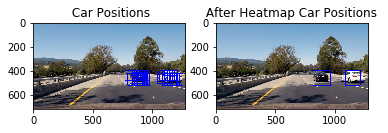

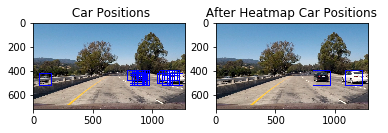

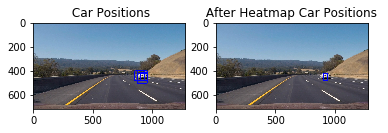

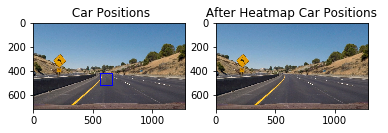

In [43]:
test_imgs = glob.glob('/Users/Yifan/Desktop/CarND/CarND-Vehicle-Detection/test_images/*.jpg')


test_img = mpimg.imread(test_imgs[0])
test_img1 = mpimg.imread(test_imgs[1])
test_img2 = mpimg.imread(test_imgs[2])	
test_img3 = mpimg.imread(test_imgs[3])
test_img4 = mpimg.imread(test_imgs[4])
test_img5 = mpimg.imread(test_imgs[5])
	

heatmap_threshold = 3


out_img = apply_sliding_window(test_img, svc, X_scaler, orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                               spatial_size=(spatial, spatial), hist_bins=histbin)
draw_img = detect_cars_with_heat(test_img, svc, X_scaler, orient, 
						pix_per_cell, cell_per_block, (spatial, spatial), histbin, 
						heatmap_threshold)

out_img1 = apply_sliding_window(test_img1, svc, X_scaler, orient, pix_per_cell, 
					cell_per_block, (spatial, spatial), histbin)
draw_img1 = detect_cars_with_heat(test_img1, svc, X_scaler, orient, 
						pix_per_cell, cell_per_block, (spatial, spatial), histbin, 
						heatmap_threshold)

out_img2 = apply_sliding_window(test_img2, svc, X_scaler,orient, pix_per_cell, 
					cell_per_block, (spatial, spatial), histbin)
draw_img2 = detect_cars_with_heat(test_img2, svc, X_scaler, orient, 
						pix_per_cell, cell_per_block, (spatial, spatial), histbin, 
						heatmap_threshold)

out_img3 = apply_sliding_window(test_img3, svc, X_scaler, orient,pix_per_cell, 
					cell_per_block, (spatial, spatial), histbin)
draw_img3 = detect_cars_with_heat(test_img3, svc, X_scaler, orient, 
						pix_per_cell, cell_per_block, (spatial, spatial), histbin, 
						heatmap_threshold)

out_img4 = apply_sliding_window(test_img4, svc, X_scaler, orient,pix_per_cell, 
					cell_per_block, (spatial, spatial), histbin)
draw_img4 = detect_cars_with_heat(test_img4, svc, X_scaler, orient, 
						pix_per_cell, cell_per_block, (spatial, spatial), histbin, 
						heatmap_threshold)

out_img5 = apply_sliding_window(test_img5, svc, X_scaler, orient, pix_per_cell, 
					cell_per_block, (spatial, spatial), histbin)
draw_img5 = detect_cars_with_heat(test_img5, svc, X_scaler, orient, 
						pix_per_cell, cell_per_block, (spatial, spatial), histbin, 
						heatmap_threshold)

ffig1 = plt.figure(1)
plt.subplot(121)
plt.imshow(out_img[0])
plt.title(' Car Positions')
plt.subplot(122)
plt.imshow(draw_img)
plt.title(' After Heatmap Car Positions ')

fig2 = plt.figure(2)
plt.subplot(121)
plt.imshow(out_img1[0])
plt.title(' Car Positions')
plt.subplot(122)
plt.imshow(draw_img1)
plt.title(' After Heatmap Car Positions ')

fig3 = plt.figure(3)
plt.subplot(121)
plt.imshow(out_img2[0])
plt.title(' Car Positions')
plt.subplot(122)
plt.imshow(draw_img2)
plt.title(' After Heatmap Car Positions ')

fig4 = plt.figure(4)
plt.subplot(121)
plt.imshow(out_img3[0])
plt.title(' Car Positions')
plt.subplot(122)
plt.imshow(draw_img3)
plt.title(' After Heatmap Car Positions ')

fig5 = plt.figure(5)
plt.subplot(121)
plt.imshow(out_img4[0])
plt.title(' Car Positions')
plt.subplot(122)
plt.imshow(draw_img4)
plt.title(' After Heatmap Car Positions ')

fig6 = plt.figure(6)
plt.subplot(121)
plt.imshow(out_img5[0])
plt.title(' Car Positions')
plt.subplot(122)
plt.imshow(draw_img5)
plt.title(' After Heatmap Car Positions ')

plt.show()



# Test with HOG 

In [ ]:
colorspace = 'YUV'
orient = 15
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

t = time.time()
car_features = hog_extract_features(cars, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell,
						cell_per_block=cell_per_block,hog_channel=hog_channel)
notcar_features = hog_extract_features(not_cars, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell,
						cell_per_block=cell_per_block,hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t),'Seconds to extract HOG features....')

X = np.vstack((car_features, notcar_features)).astype(np.float64)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using: ', orient, 'orientations', pix_per_cell, 'pixels_per_cell and', cell_per_block,
		'cells_per_block')
print('Feature vector length: ', len(X_train[0]))

##svc = MLPClassifier(solver='adam', hidden_layer_sizes=(32,8,2))
svc = LinearSVC()
#svc = SGDClassifier(loss="hinge", penalty="l2")
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t), 'Seconds to train SVC.....')
print('Test Accuracy of SVC= ', round(svc.score(X_test, y_test), 4))

t = time.time()
n_predict = 10
print('My SVC predicts', svc.predict(X_test[0:n_predict]))
print('For that ', n_predict, 'labels:', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t), 'Seconds to predict', n_predict, 'labels with SVC')



In [ ]:
test_imgs = glob.glob('/Users/Yifan/Desktop/CarND/CarND-Vehicle-Detection/test_images/*.jpg')


test_img = mpimg.imread(test_imgs[0])
test_img1 = mpimg.imread(test_imgs[1])
test_img2 = mpimg.imread(test_imgs[2])	
test_img3 = mpimg.imread(test_imgs[3])
test_img4 = mpimg.imread(test_imgs[4])
test_img5 = mpimg.imread(test_imgs[5])
	

heatmap_threshold = 2


out_img = hog_apply_sliding_window(test_img, svc, X_scaler, orient, pix_per_cell, 
					cell_per_block)
draw_img = hog_detect_cars_with_heat(test_img, svc, X_scaler, orient, 
						pix_per_cell, cell_per_block, heatmap_threshold)

out_img1 = hog_apply_sliding_window(test_img1, svc, X_scaler, orient, pix_per_cell, 
					cell_per_block)
draw_img1 = hog_detect_cars_with_heat(test_img1, svc, X_scaler, orient, 
						pix_per_cell, cell_per_block, heatmap_threshold)

out_img2 = hog_apply_sliding_window(test_img2, svc, X_scaler, orient, pix_per_cell, 
					cell_per_block)
draw_img2 = hog_detect_cars_with_heat(test_img2, svc, X_scaler, orient, 
						pix_per_cell, cell_per_block, heatmap_threshold)

out_img3 = hog_apply_sliding_window(test_img3, svc, X_scaler, orient, pix_per_cell, 
					cell_per_block)
draw_img3 = hog_detect_cars_with_heat(test_img3, svc, X_scaler, orient, 
						pix_per_cell, cell_per_block, heatmap_threshold)

out_img4 = hog_apply_sliding_window(test_img4, svc, X_scaler, orient, pix_per_cell, 
					cell_per_block)
draw_img4 = hog_detect_cars_with_heat(test_img4, svc, X_scaler, orient, 
						pix_per_cell, cell_per_block, heatmap_threshold)

out_img5 = hog_apply_sliding_window(test_img5, svc, X_scaler, orient, pix_per_cell, 
					cell_per_block)
draw_img5 = hog_detect_cars_with_heat(test_img5, svc, X_scaler, orient, 
						pix_per_cell, cell_per_block, heatmap_threshold)

ffig1 = plt.figure(1)
plt.subplot(121)
plt.imshow(out_img[0])
plt.title(' Car Positions')
plt.subplot(122)
plt.imshow(draw_img)
plt.title(' After Heatmap Car Positions ')

fig2 = plt.figure(2)
plt.subplot(121)
plt.imshow(out_img1[0])
plt.title(' Car Positions')
plt.subplot(122)
plt.imshow(draw_img1)
plt.title(' After Heatmap Car Positions ')

fig3 = plt.figure(3)
plt.subplot(121)
plt.imshow(out_img2[0])
plt.title(' Car Positions')
plt.subplot(122)
plt.imshow(draw_img2)
plt.title(' After Heatmap Car Positions ')

fig4 = plt.figure(4)
plt.subplot(121)
plt.imshow(out_img3[0])
plt.title(' Car Positions')
plt.subplot(122)
plt.imshow(draw_img3)
plt.title(' After Heatmap Car Positions ')

fig5 = plt.figure(5)
plt.subplot(121)
plt.imshow(out_img4[0])
plt.title(' Car Positions')
plt.subplot(122)
plt.imshow(draw_img4)
plt.title(' After Heatmap Car Positions ')

fig6 = plt.figure(6)
plt.subplot(121)
plt.imshow(out_img5[0])
plt.title(' Car Positions')
plt.subplot(122)
plt.imshow(draw_img5)
plt.title(' After Heatmap Car Positions ')

plt.show()


In [ ]:
from moviepy.editor import VideoFileClip 

##heatmap_threshold = 4

def process_video(img):

	out_img = hog_detect_cars_with_heat(img, svc, X_scaler, orient, pix_per_cell, 
					cell_per_block, heatmap_threshold)

	return out_img

white_output = '/Users/Yifan/Desktop/CarND/CarND-Vehicle-Detection/out_test_video.mp4'

clip1 = VideoFileClip('/Users/Yifan/Desktop/CarND/CarND-Vehicle-Detection/test_video.mp4')
white_clip = clip1.fl_image(process_video)
white_clip.write_videofile(white_output, audio=False)